In [13]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from matplotlib.ticker import MultipleLocator


## Define the arbitary tortuosity model

In [14]:
@element(num_params=4,units=["","","","",""],overwrite=True)
def arbitRCPE(p,f):
    Q, alpha, a, b = p[0], p[1], p[2], p[3]
    
    def R(x):
        # return a/(1+b*x)
        return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*R(x),y[3]*R(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
 
    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*np.cos(alpha*np.pi/2)
        lmdsin=w**alpha*Q*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1
    return Z_list


## Plot that profile here

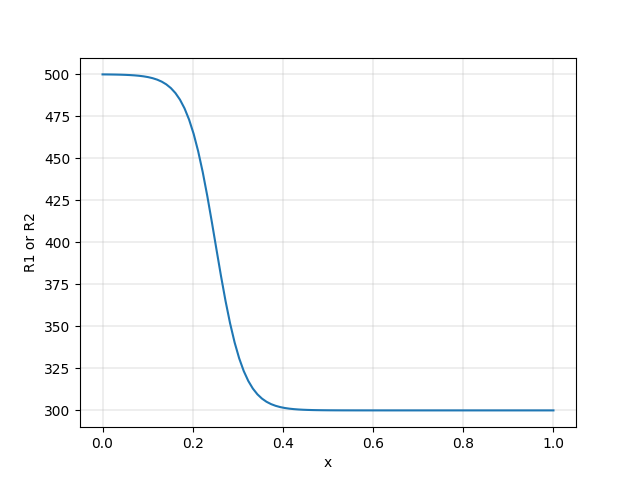

In [15]:
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
axx.plot(x,R(x))
axx.set_xlabel("x")
axx.set_ylabel("R1 or R2")
axx.grid(linewidth=0.3)

# axx2=axx.twinx()
# axx2.set_ylabel("R1")

# axx.plot([0,0.2063,0.2063,1],[873,873,387,387])

## Find Out the dip angle and the apparent R_ion

[6568.95590091 5943.61504312 5380.41445835 4873.17902072 4416.34722463
 4004.91020536 3634.35682125 3300.62419016 3000.05314372 2729.34810524
 2485.54095623 2265.95849171 2068.19310935 1890.07641093 1729.65542565
 1585.17119534 1455.03948687 1337.83341924 1232.26781576 1137.18510912
 1051.5426446   974.40124238  904.9148929   842.32147227  785.93437549
  735.13497534  689.36582376  648.12452061  610.95818185  577.45844568
  547.25696097  520.02130733  495.45130095  473.27564416  453.24888078
  435.14862203  418.77301148  403.93839987  390.47720397  378.23592625
  367.07331603  356.85865669  347.47016884  338.79352653  330.72049226
  323.14768893  315.97554115  309.10743729  302.44918344  295.90884221]
[-39731.95479908 -35783.77205154 -32227.93468363 -29025.45528998
 -26141.22080116 -23543.60749239 -21204.13424976 -19097.15029406
 -17199.55393634 -15490.53928343 -13951.36811453 -12565.16442889
 -11316.7294114  -10192.37478697  -9179.77273733  -8267.82073398
  -7446.51980537  -6706.86490

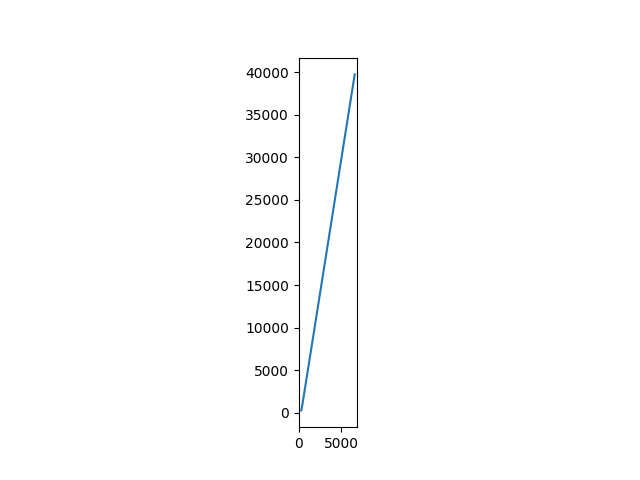

In [28]:
Q=6e-4
alpha=0.9
a=4
b=4
param=[Q,alpha,a,b]
c=CustomCircuit(initial_guess=param,circuit="arbitRCPE")
z=c.predict(frequencies=np.logspace(-2,3,100))
#found the dip angle
dip_angle=alpha*45-np.min(-np.angle(z,deg=True))

#found the Rion by finding the intercept

datax=np.real(z[:int(len(z)/2)])
datay=np.imag(z[:int(len(z)/2)])

print(datax)
print(datay)

plt.cla()
plt.plot(datax,-datay)
plt.gca().set_aspect("equal")
plt.show()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:144: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


4.268797175965155


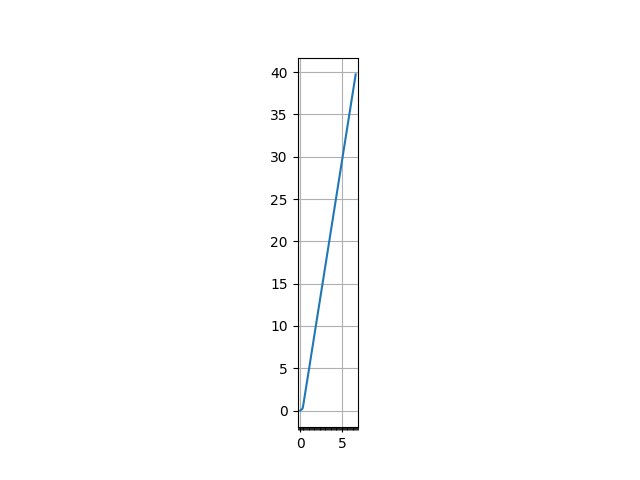

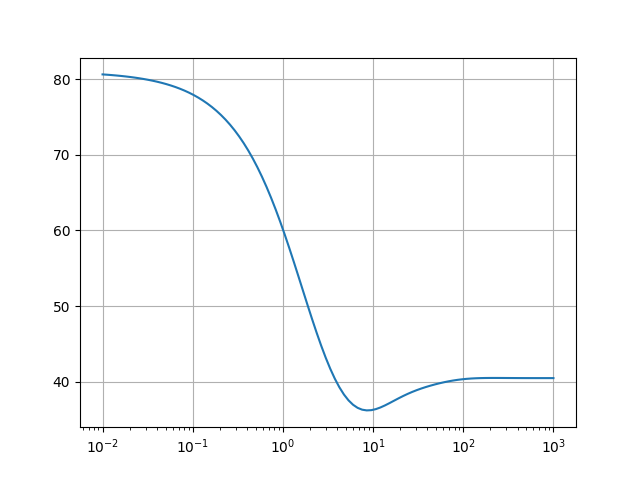

In [4]:

c=CustomCircuit(initial_guess=[6e-4,0.9,4,4],circuit="arbitRCPE")
z=c.predict(frequencies=np.logspace(-2,3,100))
fig, ax=plt.subplots()
ax.plot(np.real(z)/1000,-np.imag(z)/1000)
ax.set_aspect("equal")
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.grid(True)

fig2, ax2=plt.subplots()
ax2.plot(np.logspace(-2,3,100),-np.angle(z,deg=True))
# axx.yaxis.set_minor_locator(MultipleLocator(0.5))
ax2.set_xscale("log")
ax2.grid(True)

print(0.9*45-np.min(-np.angle(z,deg=True)))